In [1]:
from Samplers.sampler_test import *
from Samplers.plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/NHANES_adults_data_preprocessed.csv').dropna()


In [2]:
# Select the columns of interest
features = [
    'height', 'bmi', 'WHtR', 'sbp', 'dbp',
    'eGFR', 'hba1c', 'hdl', 'non_hdl', 'pulse'
]
data = data[features].dropna()

# Normalize all features (zero mean, unit variance)
for feature in features:
    data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()

# --- Compute mean and std for denormalization reference ---
mean_std_dict = {
    feat: (data[feat].mean(), data[feat].std()) for feat in ['bmi', 'sbp', 'dbp', 'hba1c', 'non_hdl', 'eGFR']
}

# --- Define standardized clinical cutoff bounds ---

# BMI (already provided example)
bmi_bounds = (np.array([18, 25, 30, np.inf]) - mean_std_dict['bmi'][0]) / mean_std_dict['bmi'][1]

# SBP: Option 2 (<140, 140–160, 160+)
sbp_bounds = (np.array([140, 160, np.inf]) - mean_std_dict['sbp'][0]) / mean_std_dict['sbp'][1]

# DBP: Option 2 (<90, 90–100, 100+)
dbp_bounds = (np.array([90, 100, np.inf]) - mean_std_dict['dbp'][0]) / mean_std_dict['dbp'][1]

# HbA1c: Option 2 (<6.5, 6.5–10.0, 10.0+)
hba1c_bounds = (np.array([6.5, 10.0, np.inf]) - mean_std_dict['hba1c'][0]) / mean_std_dict['hba1c'][1]

# Non-HDL: Option 2 (<3.36, 3.36–5.69, 5.69+)
non_hdl_bounds = (np.array([3.36, 5.69, np.inf]) - mean_std_dict['non_hdl'][0]) / mean_std_dict['non_hdl'][1]

# eGFR: Option 1 (<60, 60–90, 90+)
egfr_bounds = (np.array([60, 90, np.inf]) - mean_std_dict['eGFR'][0]) / mean_std_dict['eGFR'][1]



In [3]:
from scipy.spatial.distance import pdist

def h1(mu):
    return np.min(pdist(mu))
def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Extract values from mu

    bmi = mu[:, 1]
    sbp = mu[:, 3]
    dbp = mu[:, 4]
    hba1c = mu[:, 6]
    non_hdl = mu[:, 8]
    eGFR = mu[:, 5]

    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    dbp_blocks = np.digitize(dbp, bins=dbp_bounds)
    hba1c_blocks = np.digitize(hba1c, bins=hba1c_bounds)
    non_hdl_blocks = np.digitize(non_hdl, bins=non_hdl_bounds)
    eGFR_blocks = np.digitize(eGFR, bins=egfr_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(
        bmi_blocks, sbp_blocks, dbp_blocks, hba1c_blocks, non_hdl_blocks, eGFR_blocks
    ))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0


In [4]:
X = data.to_numpy()
corners = np.random.multivariate_normal(np.mean(X, axis=0) , np.cov(X.T), size=10)
# Mapping feature indices
feature_idx = {
    'bmi': 1,
    'sbp': 3,
    'dbp': 4,
    'hba1c': 6,
    'non_hdl': 7,
    'eGFR': 5
}

# Bounds: use lower two bins (first two thresholds)
bound_values = {
    'bmi':     [bmi_bounds[0]-0.1, bmi_bounds[2]+0.1],
    'sbp':     [sbp_bounds[0]-0.1, sbp_bounds[1]+0.1],
    'dbp':     [dbp_bounds[0]-0.1, dbp_bounds[1]+0.1],
    'hba1c':   [hba1c_bounds[0]-0.1, hba1c_bounds[1]+0.1],
    'non_hdl': [non_hdl_bounds[0]-0.1, non_hdl_bounds[1]+0.1],
    'eGFR':    [egfr_bounds[0]-0.1, egfr_bounds[1]+0.1]
}

# === Step 3: Substitute feature positions using boundary values ===
np.random.seed(42)  # for reproducibility

for k in range(10):
    for feat, idx in feature_idx.items():
        vals = bound_values[feat]
        corners[k][idx] = np.random.choice(vals)  # randomly pick one of the first two bound edges

corners


array([[ 9.64677946e-01,  1.79000000e+01,  5.46669626e-01,
         1.60100000e+02,  8.99000000e+01,  9.01000000e+01,
         6.40000000e+00,  3.26000000e+00,  1.63781079e+00,
        -3.90213308e-01],
       [-5.28142144e-01,  1.79000000e+01,  2.79229476e+00,
         1.39900000e+02,  8.99000000e+01,  5.99000000e+01,
         1.01000000e+01,  3.26000000e+00,  1.01779181e+00,
        -1.67697779e+00],
       [-8.38538716e-01,  1.79000000e+01, -5.56997131e-01,
         1.39900000e+02,  1.00100000e+02,  9.01000000e+01,
         6.40000000e+00,  5.79000000e+00,  6.82028922e-01,
        -2.67902315e-02],
       [ 8.61359728e-01,  3.01000000e+01,  8.84785530e-02,
         1.39900000e+02,  1.00100000e+02,  9.01000000e+01,
         6.40000000e+00,  5.79000000e+00,  1.65288907e-01,
        -6.58289529e-01],
       [-7.38413337e-01,  3.01000000e+01,  2.61801598e+00,
         1.60100000e+02,  1.00100000e+02,  9.01000000e+01,
         1.01000000e+01,  5.79000000e+00, -3.02791991e-01,
         2.

In [5]:

sig = 0.05
num_iterations = 500
K = 10
X = data.to_numpy() 

run_samples_rep2 = bayesian_repulsive_randomwalk(X, K, num_iterations, h2, burn_in=200, sig=sig, mu=corners)

Sampling: 100%|██████████| 500/500 [01:51<00:00,  4.47it/s]


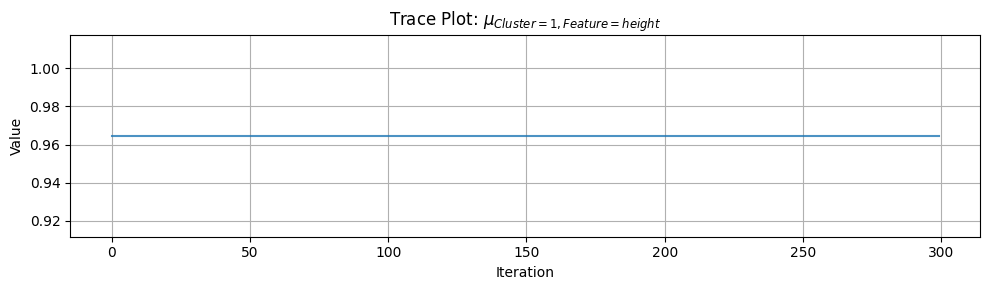

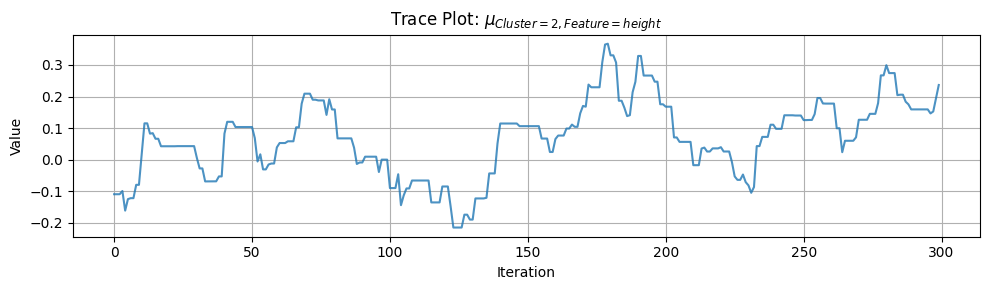

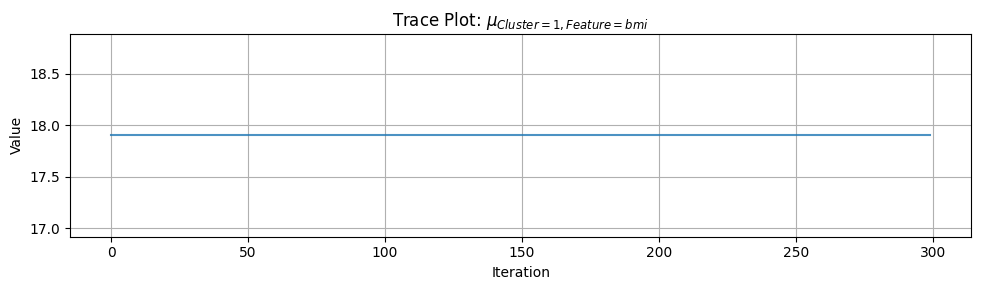

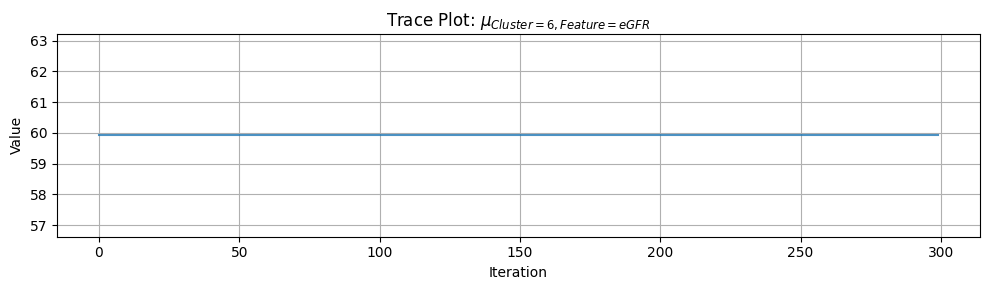

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mu samples from the non-repulsive sampler
mu_samples = np.array([s[1] for s in run_samples_rep2])  # shape: (T, K, p)
T, K, p = mu_samples.shape
feature_names = data.columns  # assuming this has p features

# === Choose a few (k, d) pairs to visualize ===
plot_targets = [
    (0, 0),  # Cluster 1, height
    (1, 0),  # Cluster 2, height
    (0, 1),  # Cluster 1, bmi
    (5, 5),  # Cluster 2, bmi
]

# === Plot trace plots ===
for (k, d) in plot_targets:
    plt.figure(figsize=(10, 3))
    plt.plot(mu_samples[:, k, d], alpha=0.8)
    plt.title(f'Trace Plot: $\mu_{{Cluster={k+1}, Feature={feature_names[d]}}}$')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Cluster 1, Feature height has zero variance. Skipping KDE plot.
Cluster 8, Feature height has zero variance. Skipping KDE plot.
Cluster 9, Feature height has zero variance. Skipping KDE plot.
Cluster 10, Feature height has zero variance. Skipping KDE plot.


/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/fw/cl62311d3y1_dgsvr1tft4f80000gn/T/ipykernel_38223/2006533761.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(values, label=f'Cluster {k+1}', fill=True, alpha=0.3)
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

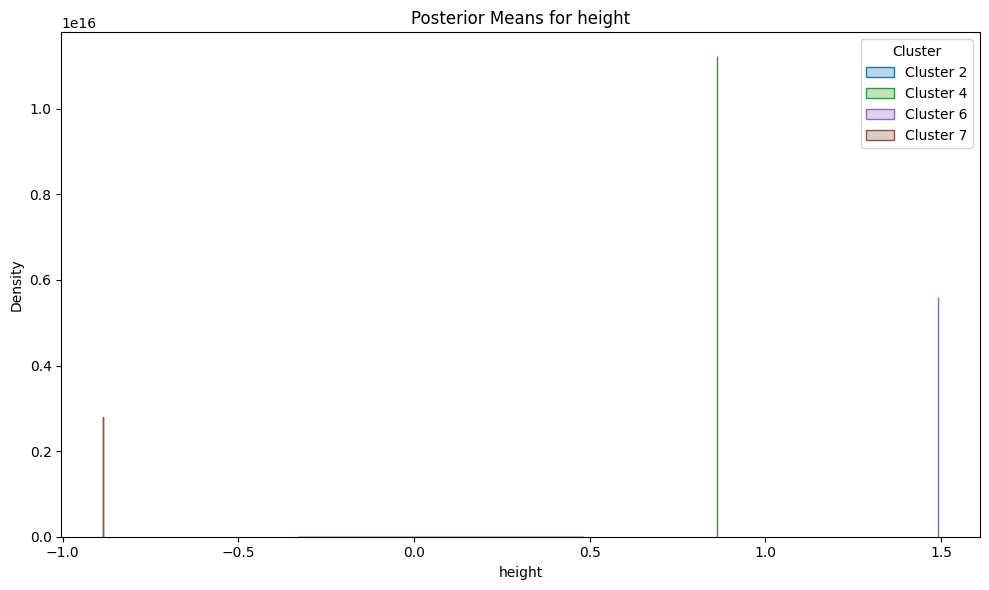

Cluster 1, Feature bmi has zero variance. Skipping KDE plot.
Cluster 3, Feature bmi has zero variance. Skipping KDE plot.
Cluster 10, Feature bmi has zero variance. Skipping KDE plot.


/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

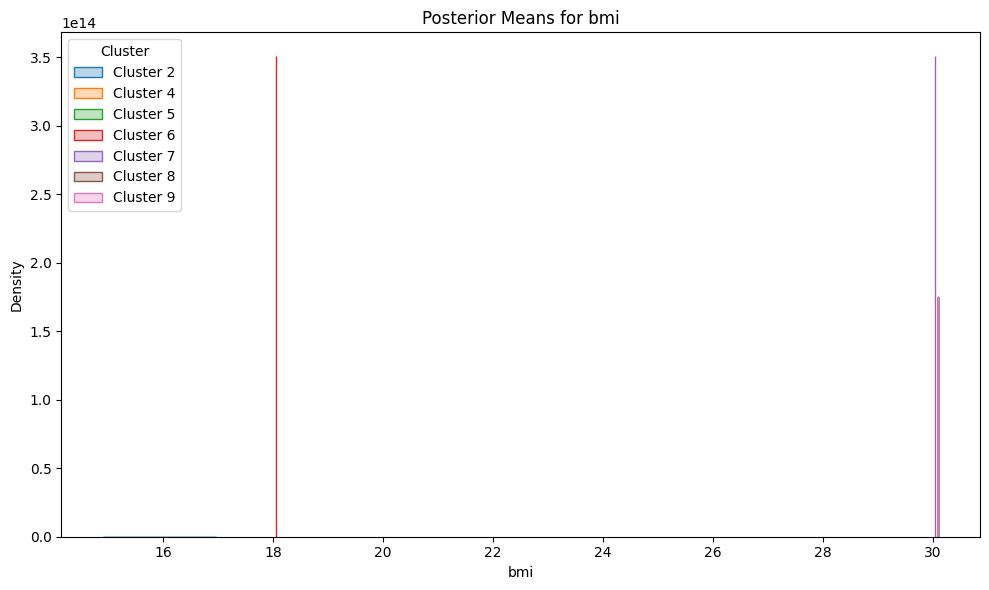

Cluster 4, Feature WHtR has zero variance. Skipping KDE plot.
Cluster 5, Feature WHtR has zero variance. Skipping KDE plot.
Cluster 6, Feature WHtR has zero variance. Skipping KDE plot.
Cluster 7, Feature WHtR has zero variance. Skipping KDE plot.
Cluster 8, Feature WHtR has zero variance. Skipping KDE plot.


/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/fw/cl62311d3y1_dgsvr1tft4f80000gn/T/ipykernel_38223/2006533761.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=Fa

Cluster 10, Feature WHtR has zero variance. Skipping KDE plot.


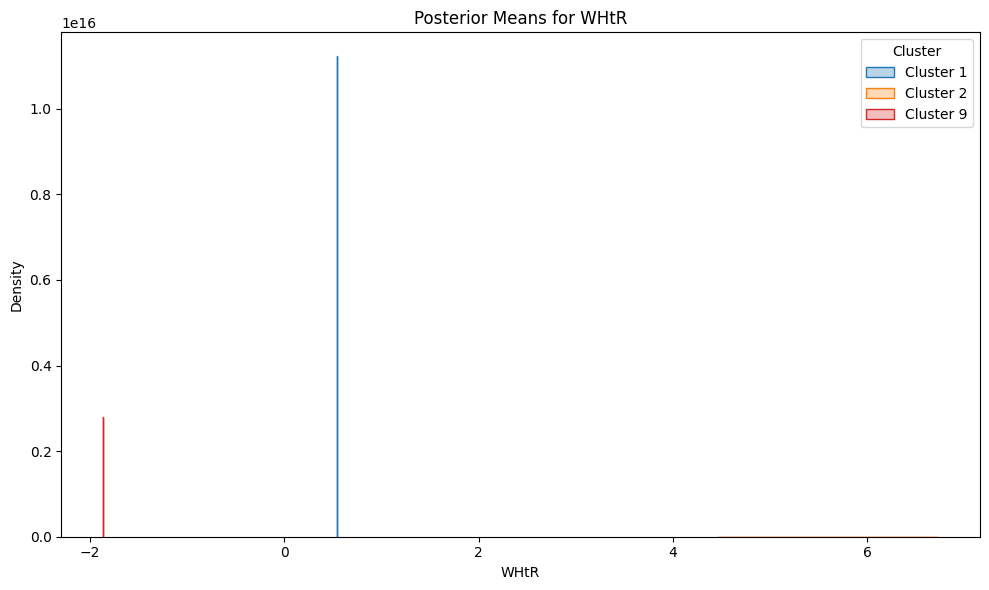

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

Cluster 1, Feature sbp has zero variance. Skipping KDE plot.
Cluster 5, Feature sbp has zero variance. Skipping KDE plot.
Cluster 7, Feature sbp has zero variance. Skipping KDE plot.
Cluster 8, Feature sbp has zero variance. Skipping KDE plot.
Cluster 9, Feature sbp has zero variance. Skipping KDE plot.
Cluster 10, Feature sbp has zero variance. Skipping KDE plot.


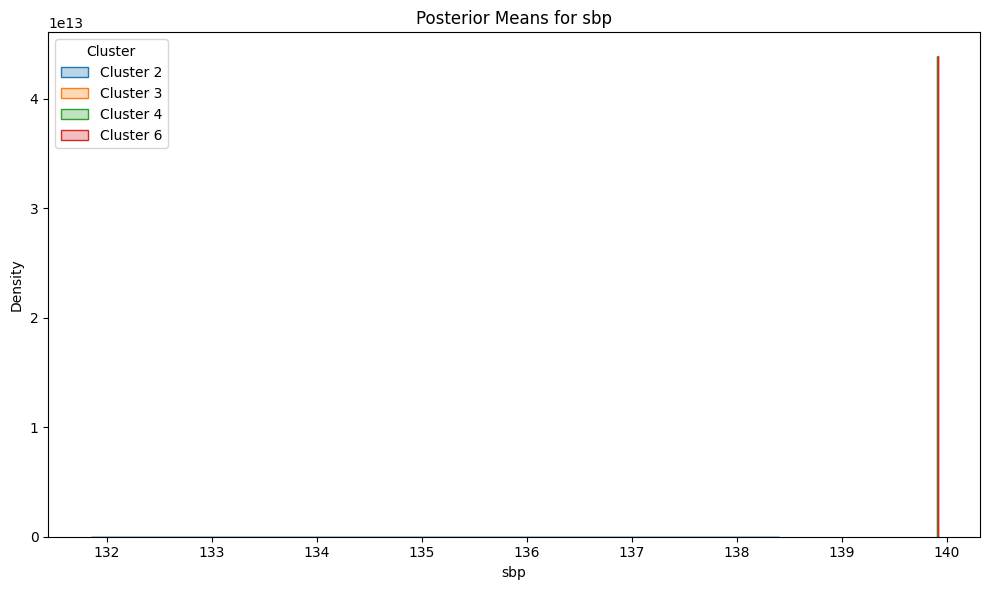

Cluster 1, Feature dbp has zero variance. Skipping KDE plot.
Cluster 7, Feature dbp has zero variance. Skipping KDE plot.
Cluster 9, Feature dbp has zero variance. Skipping KDE plot.


/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

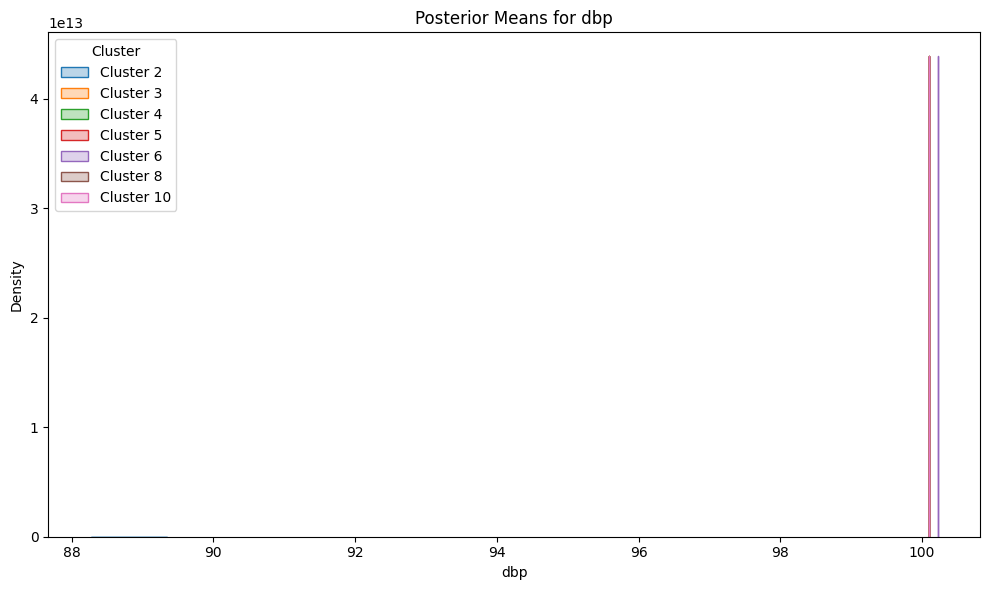

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

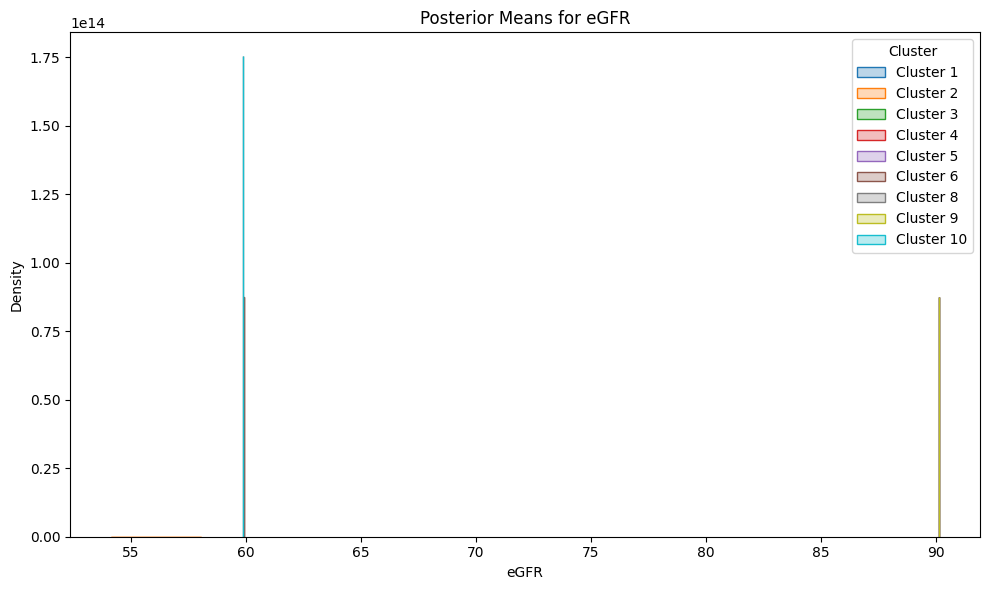

Cluster 5, Feature hba1c has zero variance. Skipping KDE plot.
Cluster 6, Feature hba1c has zero variance. Skipping KDE plot.
Cluster 8, Feature hba1c has zero variance. Skipping KDE plot.
Cluster 9, Feature hba1c has zero variance. Skipping KDE plot.


/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/fw/cl62311d3y1_dgsvr1tft4f80000gn/T/ipykernel_38223/2006533761.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(values, label=f'Cluster {k+1}', fill=True, alpha=0.3)
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

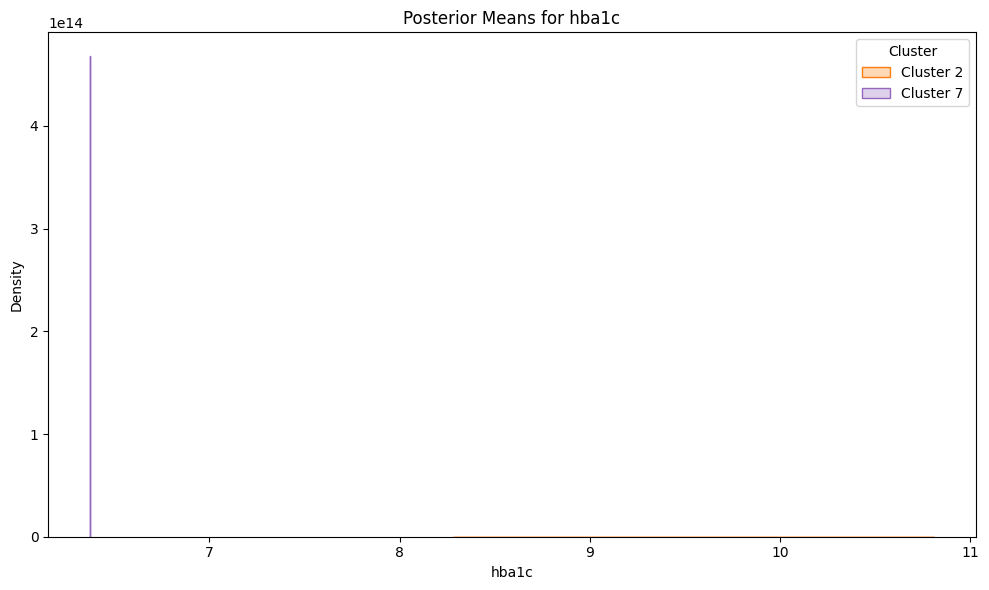

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

Cluster 6, Feature hdl has zero variance. Skipping KDE plot.


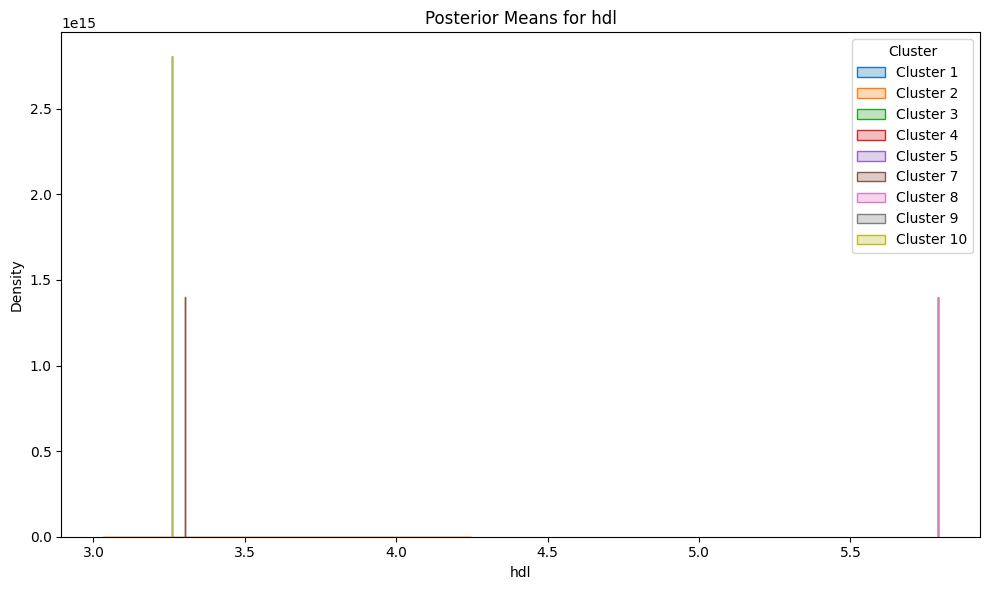

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Cluster 4, Feature non_hdl has zero variance. Skipping KDE plot.
Cluster 5, Feature non_hdl has zero variance. Skipping KDE plot.
Cluster 7, Feature non_hdl has zero variance. Skipping KDE plot.


/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/fw/cl62311d3y1_dgsvr1tft4f80000gn/T/ipykernel_38223/2006533761.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=Fa

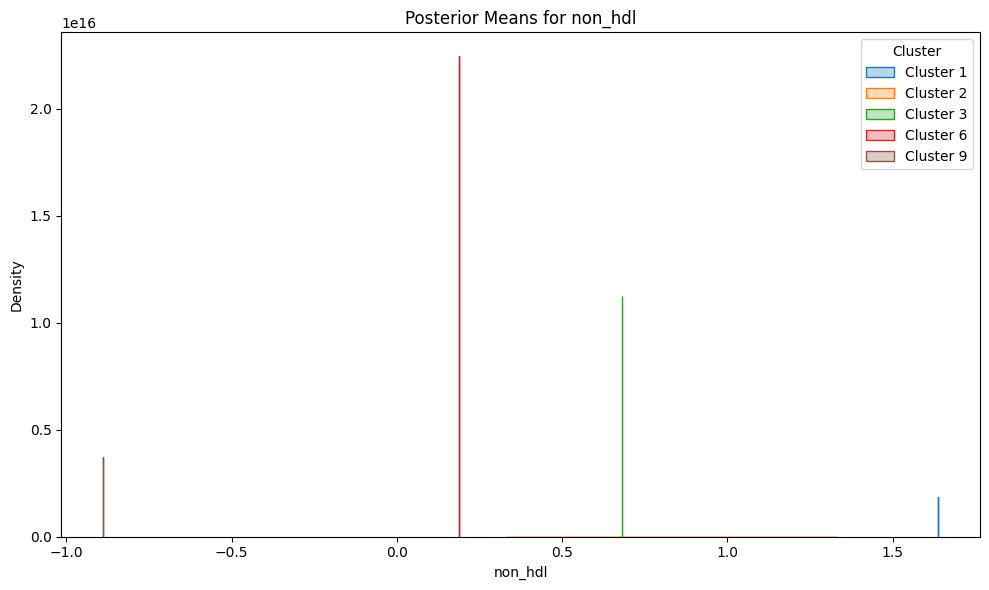

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

Cluster 1, Feature pulse has zero variance. Skipping KDE plot.
Cluster 8, Feature pulse has zero variance. Skipping KDE plot.
Cluster 10, Feature pulse has zero variance. Skipping KDE plot.


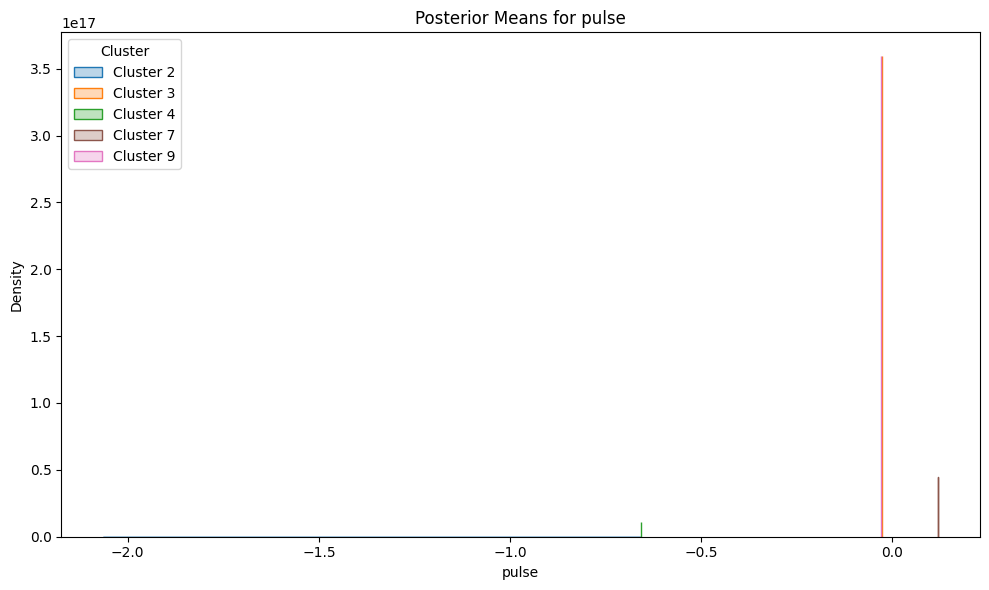

In [7]:
# mu_samples shape is (T, K, p)
# T is the number of samples, K is the number of clusters, and p is the number of features
mu_samples = np.array([s[1] for s in run_samples_rep2])  # extract mu
T, K, p = mu_samples.shape
feature_names = data.columns
for d in range(p):
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of mu_k[:, d] for each cluster
    for k in range(K):
        values = mu_samples[:, k, d]  # T samples for mu_k, feature d
        if np.var(values) == 0:  # Check for zero variance
            print(f"Cluster {k+1}, Feature {feature_names[d]} has zero variance. Skipping KDE plot.")
            continue
        sns.kdeplot(values, label=f'Cluster {k+1}', fill=True, alpha=0.3)
    
    plt.title(f'Posterior Means for {feature_names[d]}')
    plt.xlabel(feature_names[d])
    plt.ylabel('Density')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

In [15]:
sig = 0.1
num_iterations = 5000
K = 10
X = data.to_numpy() 


run_samples_rep1 = bayesian_repulsive_randomwalk_high(X, K, num_iterations, h1, burn_in=2000, sig=sig)

Sampling: 100%|██████████| 5000/5000 [59:52<00:00,  1.39it/s]     


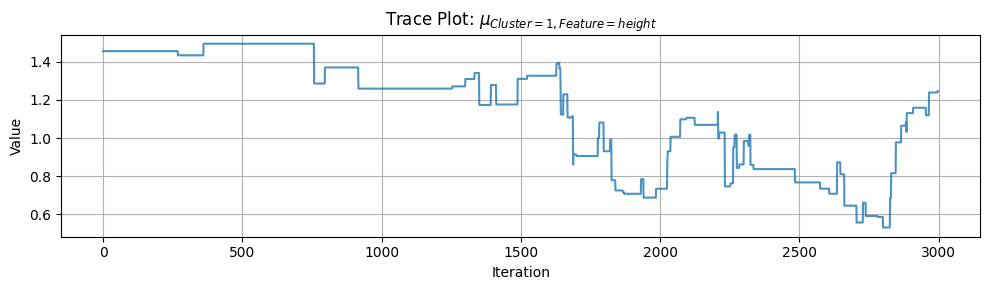

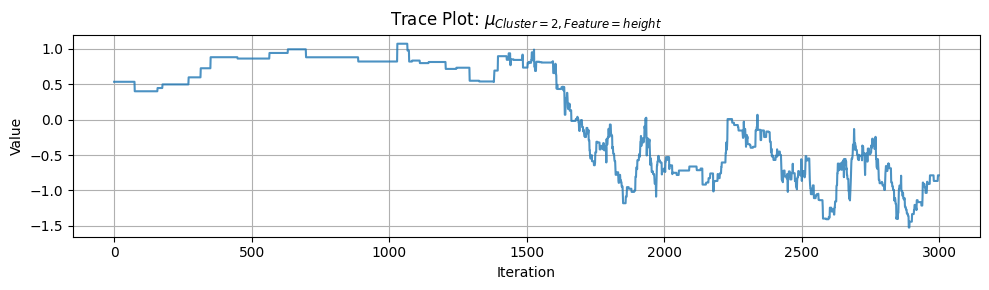

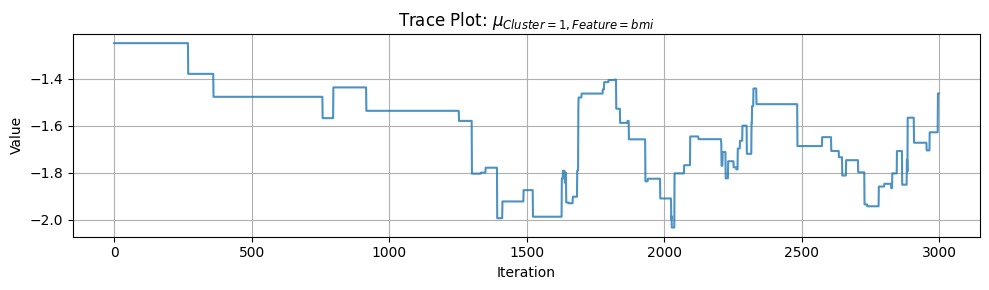

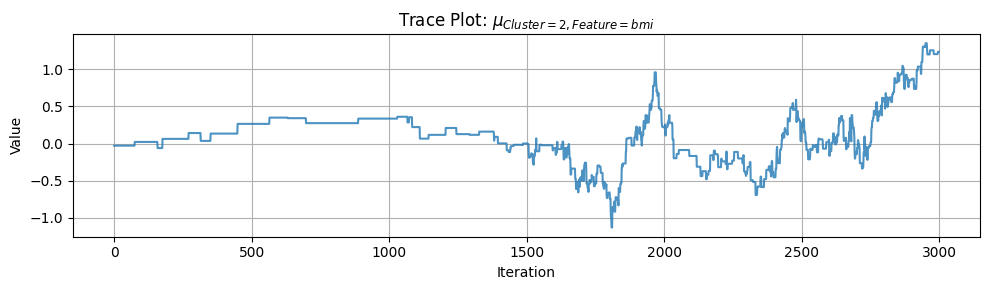

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mu samples from the non-repulsive sampler
mu_samples = np.array([s[1] for s in run_samples_rep1])  # shape: (T, K, p)
T, K, p = mu_samples.shape
feature_names = data.columns  # assuming this has p features

# === Choose a few (k, d) pairs to visualize ===
plot_targets = [
    (0, 0),  # Cluster 1, height
    (1, 0),  # Cluster 2, height
    (0, 1),  # Cluster 1, bmi
    (1, 1),  # Cluster 2, bmi
]

# === Plot trace plots ===
for (k, d) in plot_targets:
    plt.figure(figsize=(10, 3))
    plt.plot(mu_samples[:, k, d], alpha=0.8)
    plt.title(f'Trace Plot: $\mu_{{Cluster={k+1}, Feature={feature_names[d]}}}$')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

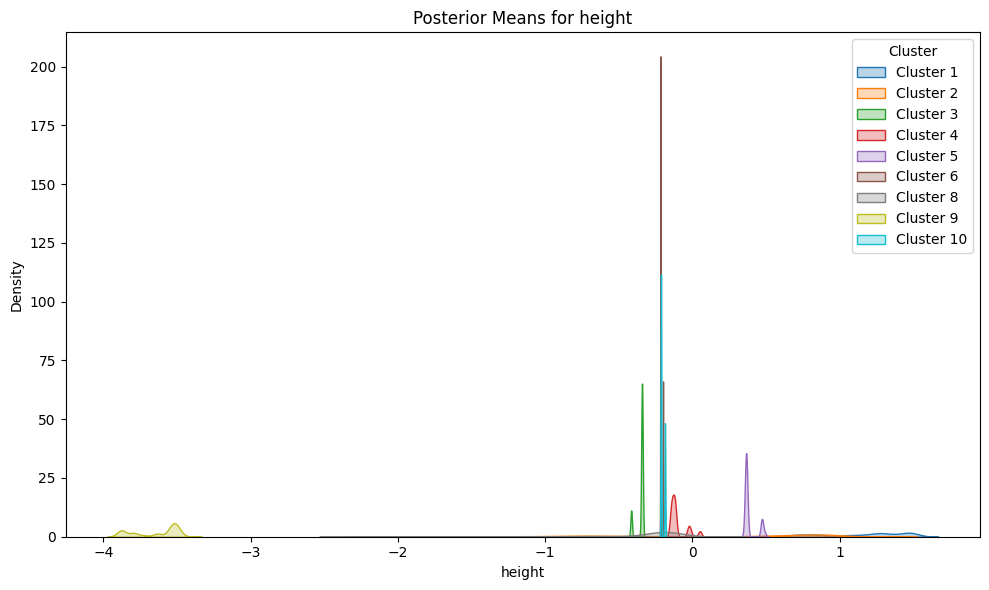

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

Cluster 7, Feature bmi has zero variance. Skipping KDE plot.


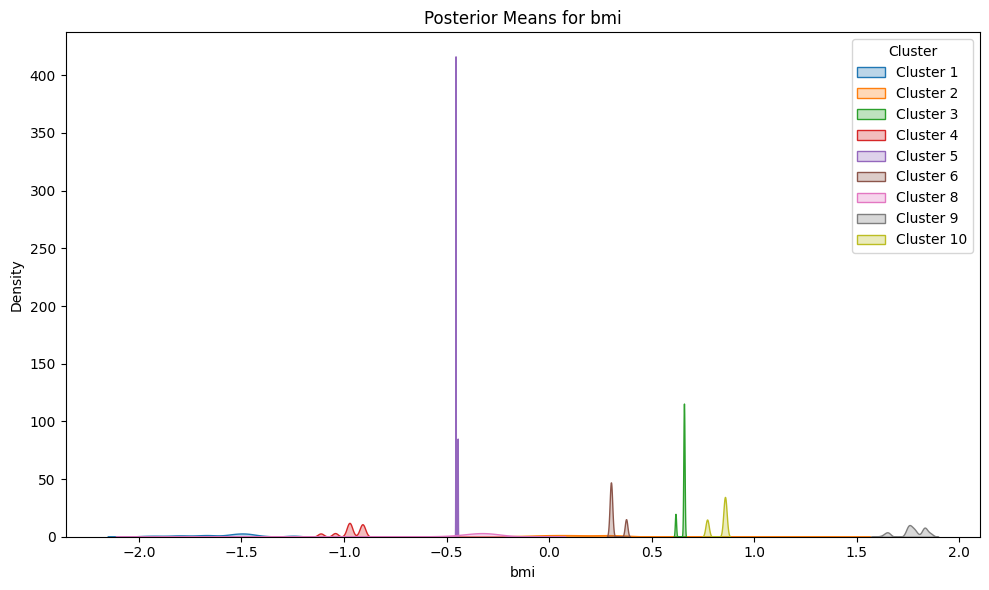

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

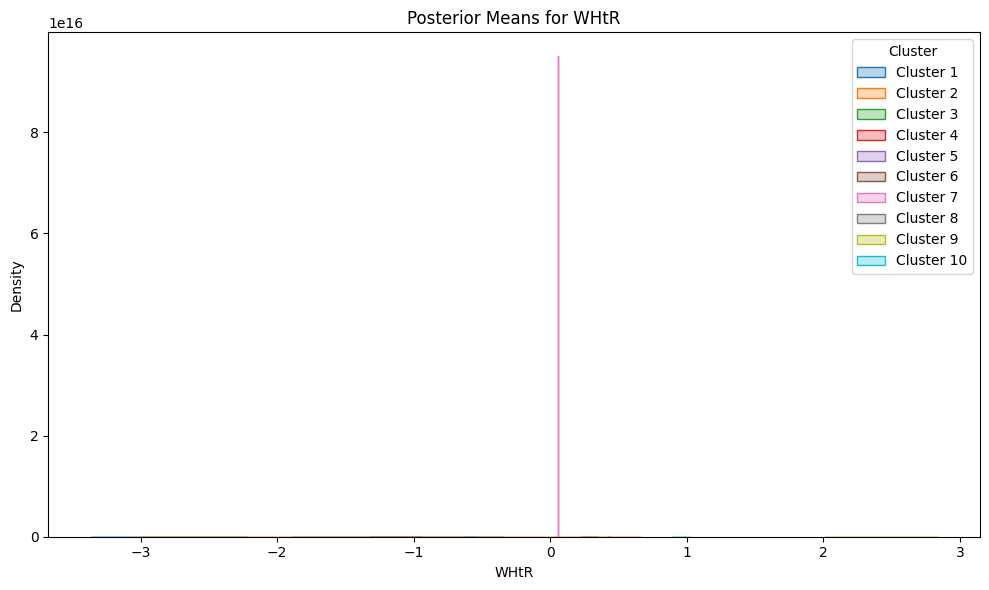

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

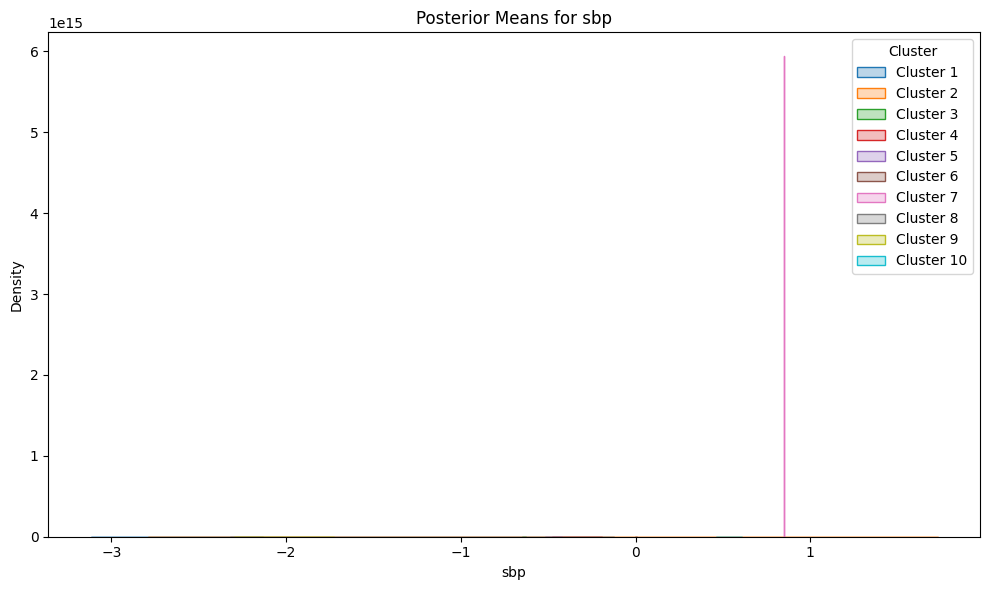

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

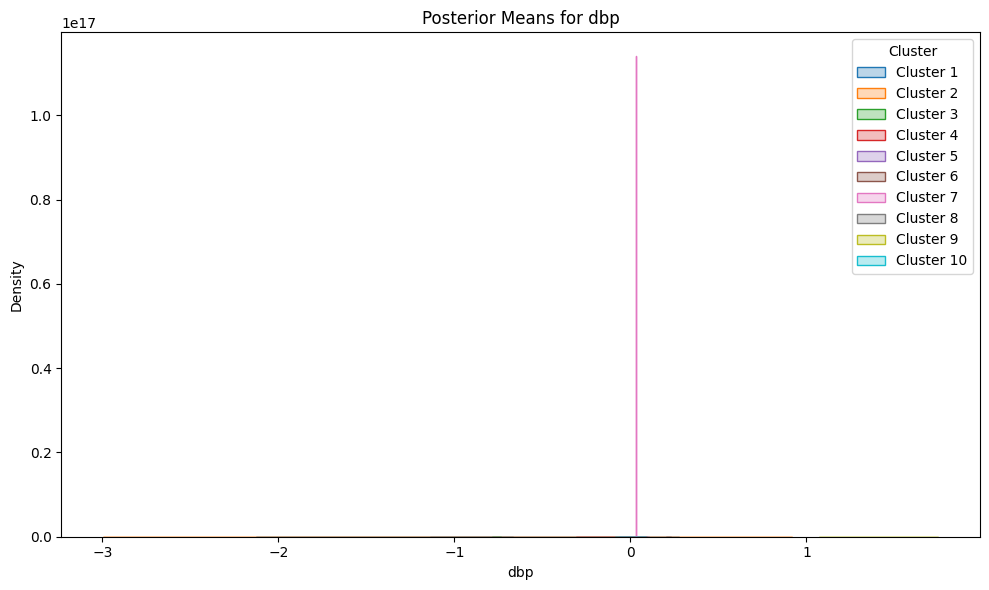

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

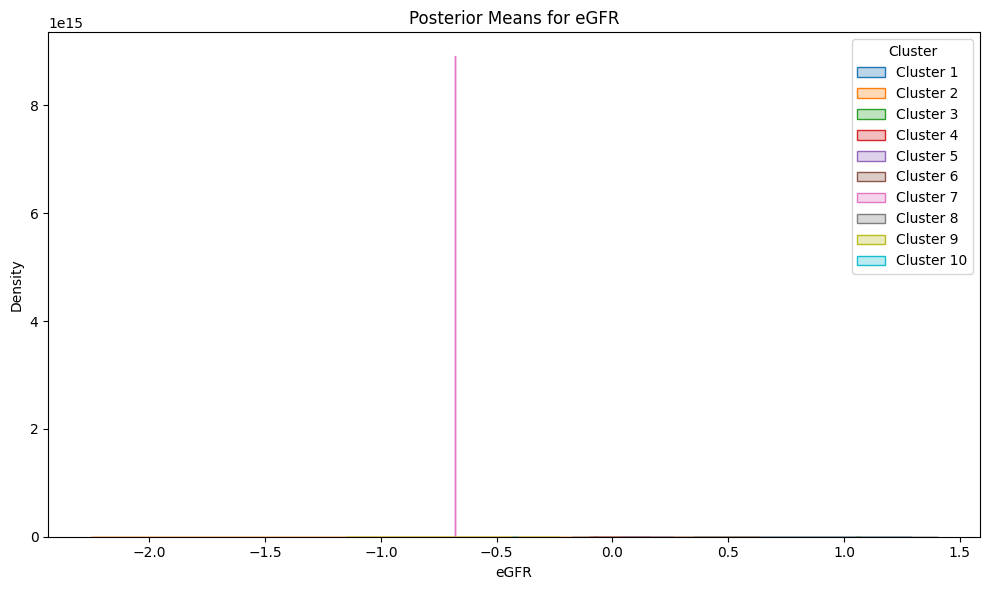

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

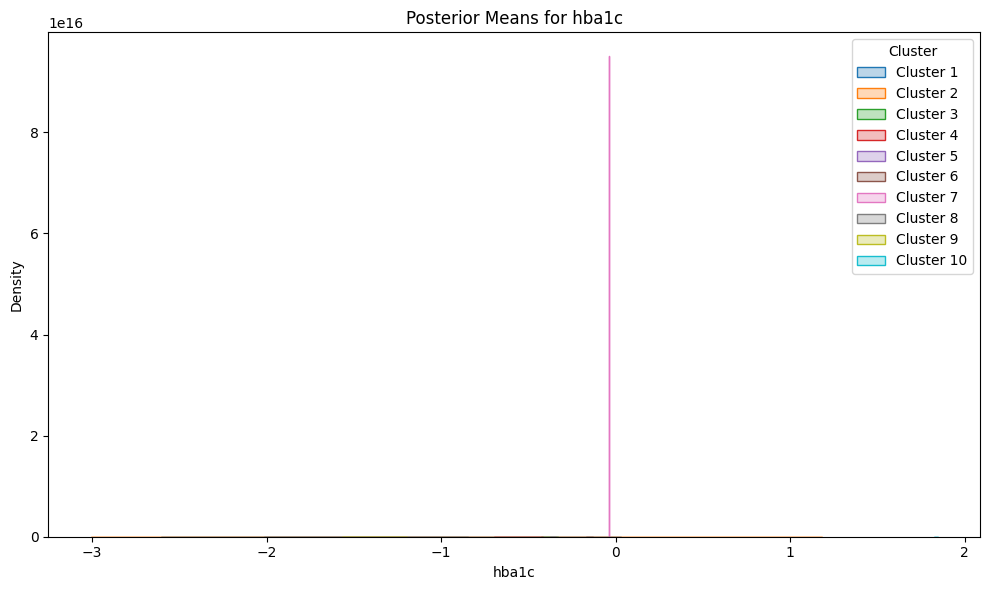

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

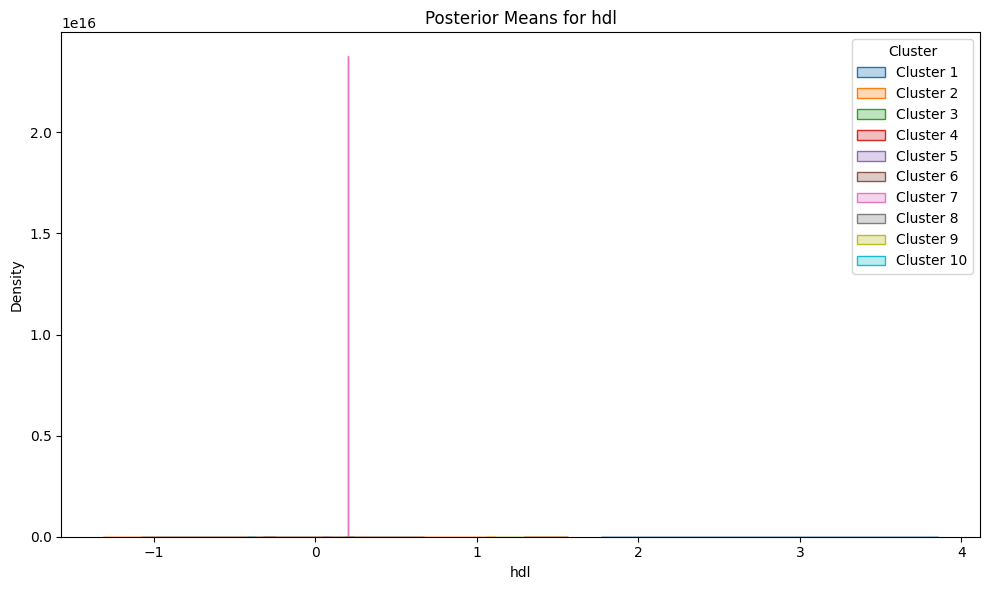

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

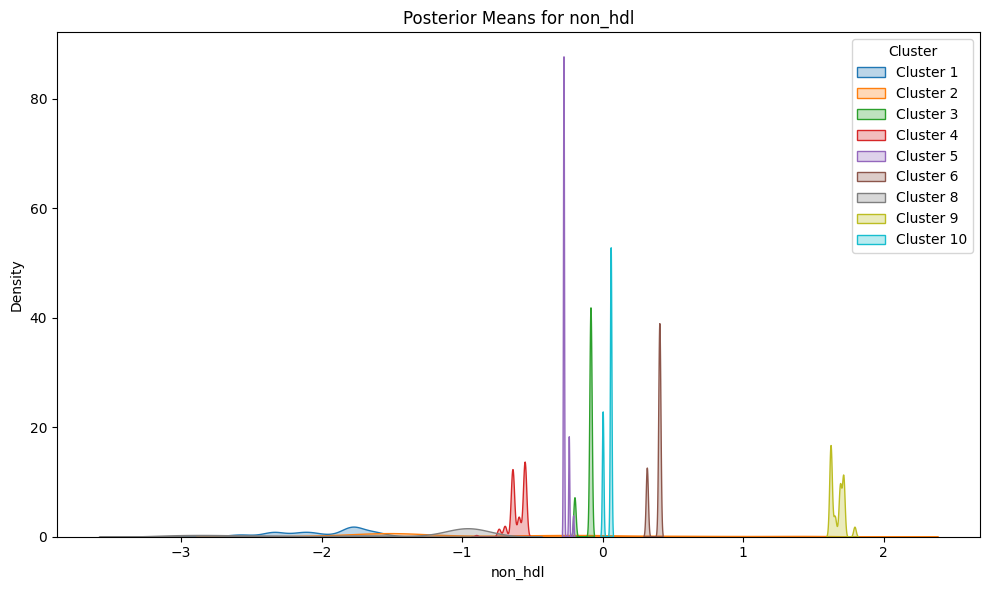

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liyiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

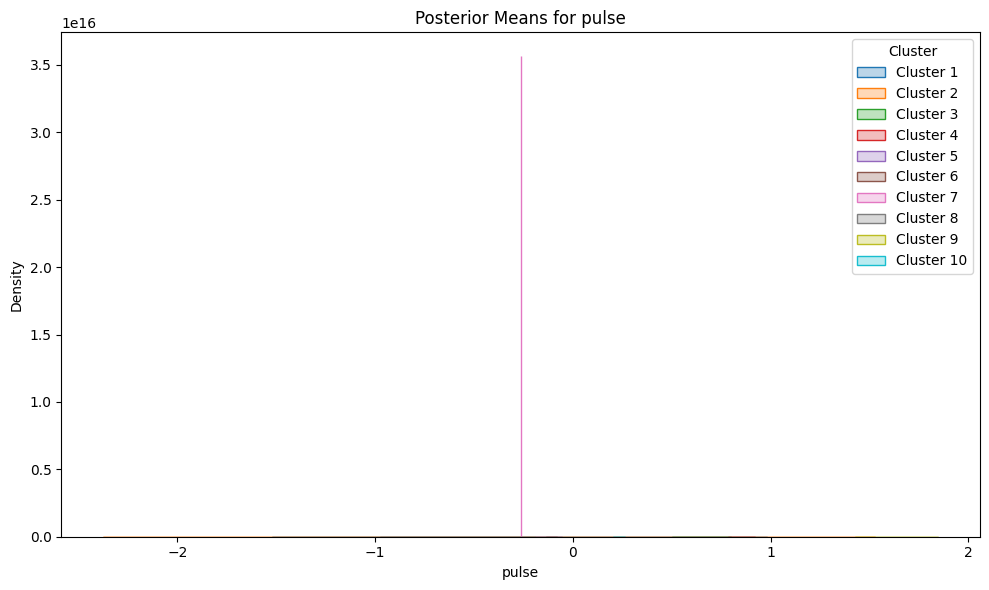

In [18]:
# mu_samples shape is (T, K, p)
# T is the number of samples, K is the number of clusters, and p is the number of features
mu_samples = np.array([s[1] for s in run_samples_rep1])  # extract mu
T, K, p = mu_samples.shape
feature_names = data.columns
for d in range(p):
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of mu_k[:, d] for each cluster
    for k in range(K):
        values = mu_samples[:, k, d]  # T samples for mu_k, feature d
        if np.var(values) == 0:  # Check for zero variance
            print(f"Cluster {k+1}, Feature {feature_names[d]} has zero variance. Skipping KDE plot.")
            continue
        sns.kdeplot(values, label=f'Cluster {k+1}', fill=True, alpha=0.3)
    
    plt.title(f'Posterior Means for {feature_names[d]}')
    plt.xlabel(feature_names[d])
    plt.ylabel('Density')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

In [ ]:
num_iterations = 5000
K = 10
X = data.to_numpy() 

run_samples_nonrep = gibbs_sampler_gmm_multivariate(X, K, num_iterations, burn_in=1000)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mu samples from the non-repulsive sampler
mu_samples = np.array([s[1] for s in run_samples_nonrep])  # shape: (T, K, p)
T, K, p = mu_samples.shape
feature_names = data.columns  # assuming this has p features

# === Choose a few (k, d) pairs to visualize ===
plot_targets = [
    (0, 0),  # Cluster 1, height
    (1, 0),  # Cluster 2, height
    (0, 1),  # Cluster 1, bmi
    (1, 1),  # Cluster 2, bmi
]

# === Plot trace plots ===
for (k, d) in plot_targets:
    plt.figure(figsize=(10, 3))
    plt.plot(mu_samples[:, k, d], alpha=0.8)
    plt.title(f'Trace Plot: $\mu_{{Cluster={k+1}, Feature={feature_names[d]}}}$')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

NameError: name 'run_samples_nonrep' is not defined

In [ ]:
for d in range(p):
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of mu_k[:, d] for each cluster
    for k in range(K):
        values = mu_samples[:, k, d]  # T samples for mu_k, feature d
        sns.kdeplot(values, label=f'Cluster {k+1}', fill=True, alpha=0.3)

    plt.title(f'Posterior Means for {feature_names[d]}')
    plt.xlabel(feature_names[d])
    plt.ylabel('Density')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import pdist

# def compute_distance_trace(mu_samples, mode='min'):
#     """
#     Computes a trace of distance statistics (min, mean, max) between cluster means.

#     Parameters:
#         mu_samples: ndarray of shape (T, K, p)
#         mode: str, 'min', 'mean', or 'max'

#     Returns:
#         trace: ndarray of shape (T,)
#     """
#     trace = []
#     for mu in mu_samples:
#         dists = pdist(mu)  # All pairwise Euclidean distances between cluster means
#         if mode == 'min':
#             trace.append(np.min(dists))
#         elif mode == 'mean':
#             trace.append(np.mean(dists))
#         elif mode == 'max':
#             trace.append(np.max(dists))
#         else:
#             raise ValueError("mode must be 'min', 'mean', or 'max'")
#     return np.array(trace)

# === Extract mu samples ===
mu_rep1 = np.array([s[1] for s in run_samples_rep1])     # shape: (T, K, p)
mu_norep = np.array([s[1] for s in run_samples_nonrep]) # shape: (T, K, p)
mu_rep2 = np.array([s[1] for s in run_samples_rep2])     # shape: (T, K, p)

# === Compute distance traces ===
dist_min_rep1 = mu_distance_trace(mu_rep1, mode='min')
dist_mean_rep1 = mu_distance_trace(mu_rep1, mode='mean')

dist_min_rep2 = mu_distance_trace(mu_rep2, mode='min')
dist_mean_rep2 = mu_distance_trace(mu_rep2, mode='mean')

dist_min_norep = mu_distance_trace(mu_norep, mode='min')
dist_mean_norep = mu_distance_trace(mu_norep, mode='mean')

# === Plotting ===
plt.figure(figsize=(14, 5))

# --- Minimum Distance Trace ---
plt.subplot(1, 2, 1)
plt.plot(dist_min_norep, label='No Repulsion', color='tab:blue', alpha=0.7)
plt.plot(dist_min_rep1, label='With Repulsion (h1)', color='tab:red', alpha=0.7)
plt.plot(dist_min_rep2, label='With Repulsion (h2)', color='tab:green', alpha=0.7)
plt.title('Minimum Distance Between Cluster Means')
plt.xlabel('Iteration')
plt.ylabel('Min Distance')
plt.legend()
plt.grid(True)

# --- Mean Distance Trace ---
plt.subplot(1, 2, 2)
plt.plot(dist_mean_norep, label='No Repulsion', color='tab:blue', alpha=0.7)
plt.plot(dist_mean_rep1, label='With Repulsion (h1)', color='tab:red', alpha=0.7)
plt.plot(dist_mean_rep2, label='With Repulsion (h2)', color='tab:green', alpha=0.7)
plt.title('Mean Distance Between Cluster Means')
plt.xlabel('Iteration')
plt.ylabel('Mean Distance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()